In [1]:
# !pip install interpret
# !pip install --user xgboost
# !pip install pytorch-tabnet
# !pip install anchor-exp

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from interpret import preserve, show
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

random_state=42

In [3]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
df = pd.DataFrame(np.c_[cancer['data'], cancer['target']],
                  columns= np.append(cancer['feature_names'], ['target']))
df.target = df.target.astype(np.int64)
_class = 'target'
class_names = [0, 1]

In [4]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [6]:
X, y = df.drop(columns=[_class]), df[_class]

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=random_state)

In [8]:
x_test.shape

(171, 30)

In [9]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 149 to 102
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              398 non-null    float64
 1   mean texture             398 non-null    float64
 2   mean perimeter           398 non-null    float64
 3   mean area                398 non-null    float64
 4   mean smoothness          398 non-null    float64
 5   mean compactness         398 non-null    float64
 6   mean concavity           398 non-null    float64
 7   mean concave points      398 non-null    float64
 8   mean symmetry            398 non-null    float64
 9   mean fractal dimension   398 non-null    float64
 10  radius error             398 non-null    float64
 11  texture error            398 non-null    float64
 12  perimeter error          398 non-null    float64
 13  area error               398 non-null    float64
 14  smoothness error        

# ML Model

In [10]:
import sklearn.metrics
import pandas as pd
import time
import numpy as np

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from interpret.glassbox import ExplainableBoostingClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

In [12]:
random_state=42

In [13]:
x_train

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
149,13.740,17.91,88.12,585.0,0.07944,0.06376,0.02881,0.01329,0.1473,0.05580,...,15.340,22.46,97.19,725.9,0.09711,0.18240,0.15640,0.06019,0.2350,0.07014
124,13.370,16.39,86.10,553.5,0.07115,0.07325,0.08092,0.02800,0.1422,0.05823,...,14.260,22.75,91.99,632.1,0.10250,0.25310,0.33080,0.08978,0.2048,0.07628
421,14.690,13.98,98.22,656.1,0.10310,0.18360,0.14500,0.06300,0.2086,0.07406,...,16.460,18.34,114.10,809.2,0.13120,0.36350,0.32190,0.11080,0.2827,0.09208
195,12.910,16.33,82.53,516.4,0.07941,0.05366,0.03873,0.02377,0.1829,0.05667,...,13.880,22.00,90.81,600.6,0.10970,0.15060,0.17640,0.08235,0.3024,0.06949
545,13.620,23.23,87.19,573.2,0.09246,0.06747,0.02974,0.02443,0.1664,0.05801,...,15.350,29.09,97.58,729.8,0.12160,0.15170,0.10490,0.07174,0.2642,0.06953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,8.888,14.64,58.79,244.0,0.09783,0.15310,0.08606,0.02872,0.1902,0.08980,...,9.733,15.67,62.56,284.4,0.12070,0.24360,0.14340,0.04786,0.2254,0.10840
106,11.640,18.33,75.17,412.5,0.11420,0.10170,0.07070,0.03485,0.1801,0.06520,...,13.140,29.26,85.51,521.7,0.16880,0.26600,0.28730,0.12180,0.2806,0.09097
270,14.290,16.82,90.30,632.6,0.06429,0.02675,0.00725,0.00625,0.1508,0.05376,...,14.910,20.65,94.44,684.6,0.08567,0.05036,0.03866,0.03333,0.2458,0.06120
435,13.980,19.62,91.12,599.5,0.10600,0.11330,0.11260,0.06463,0.1669,0.06544,...,17.040,30.80,113.90,869.3,0.16130,0.35680,0.40690,0.18270,0.3179,0.10550


In [14]:
def classify_report(clfs, dataset):
    x_train, y_train, x_test, y_test = dataset
    data = []
    for clf, name, no_df in clfs:
        if no_df:
            x_tr, x_te = x_train, x_test
        else:
            x_tr, x_te = x_train.values,  x_test.values
        clf.fit(x_tr, y_train)
        pred = clf.predict(x_te)
        f1, acc = sklearn.metrics.f1_score(y_test, pred, average='binary'), sklearn.metrics.accuracy_score(y_test, pred)
        data.append([name, f1, acc])
    df = pd.DataFrame(data, columns = ['Name', 'F1', 'Acc.'])
    df = df.sort_values(by=['F1'])
    return df

In [15]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=random_state)
gbc = GradientBoostingClassifier(random_state=random_state)
_xgb = xgb.XGBClassifier(random_state=random_state)
ebm = ExplainableBoostingClassifier(random_state=random_state)
tbn = TabNetClassifier(verbose=0, seed=random_state)

clfs = [(rf, 'rf', True), (gbc, 'gbc', True), (_xgb, 'xgb', True), (ebm, 'ebm', True), (tbn, 'tbn', False)]
# clfs = [(rf, 'rf', True), (ebm, 'ebm', True), (tbn, 'tbn', False)]
dataset = x_train, y_train, x_test, y_test
classify_report(clfs, dataset)

,Name,F1,Acc.
4,tbn,0.507614,0.432749
1,gbc,0.967742,0.959064
2,xgb,0.976744,0.970760
0,rf,0.977169,0.970760
3,ebm,0.981651,0.976608


# RF Importance

In [16]:
selected_model = rf

class_names = ['NO','YES']
feature_names = x_train.columns.to_list()

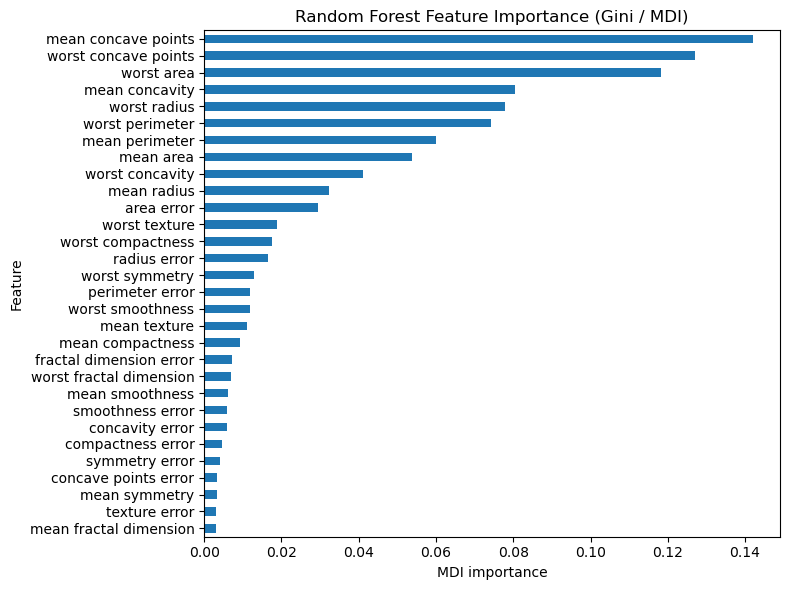

In [17]:
# If selected_model is a Pipeline, grab its final estimator for feature_importances_
final_est = getattr(selected_model, "steps", None)
final_est = final_est[-1][1] if final_est else selected_model

if not hasattr(final_est, "feature_importances_"):
    raise ValueError("Current estimator does not expose .feature_importances_ (MDI).")

gini_series = pd.Series(final_est.feature_importances_, index=feature_names)
gini_series = gini_series.sort_values(ascending=True)

ax = gini_series.plot.barh(figsize=(8, 6))
ax.set_title("Random Forest Feature Importance (Gini / MDI)")
ax.set_xlabel("MDI importance")
ax.set_ylabel("Feature")
plt.tight_layout()
# plt.savefig("figs_global_importance/focal_model_gini_importance.png", dpi=300)
plt.show()


Elapsed time to compute the importances: 1.012 seconds


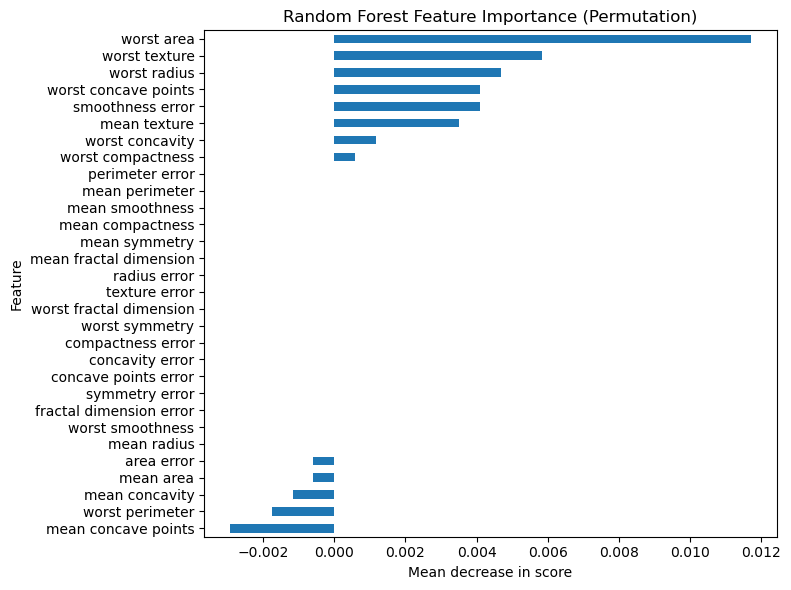

In [18]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    selected_model, x_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

selected_model_importances = pd.Series(
    result.importances_mean, index=feature_names
).sort_values(ascending=True)

ax = selected_model_importances.plot.barh(figsize=(8, 6))
ax.set_title("Random Forest Feature Importance (Permutation)")
ax.set_xlabel("Mean decrease in score")
ax.set_ylabel("Feature")
plt.tight_layout()
# plt.savefig("figs_global_importance/focal_model_permutation_importance.png", dpi=300)
plt.show()